In [ ]:
# installation via PyPI
!pip install -U mobile-env
!pip install numpngw # for video render

In [ ]:
import warnings
# Ignoring a specific deprecation warning
warnings.filterwarnings("ignore")

In [ ]:
import gymnasium
import matplotlib.pyplot as plt
import mobile_env
import numpy as np
from numpngw import write_apng
from IPython.display import Image, display
import seaborn as sns
from collections import OrderedDict

sns.set_style("whitegrid")


In [ ]:
# overall number of active connections
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}


# monitors each user equipments' distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestations
    bpos = np.array([[bs.x, bs.y] for bs in sim.stations.values()])

    distances = {}
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2, axis=1)).min()

        distances[ue_id] = dist

    return distances


# number of connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}


In [ ]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment
from mobile_env.handlers.multi_agent import MComMAHandler

class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # 10 steps per episode
            "EP_MAX_TIME": 100,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
            "metrics": {
            "scalar_metrics": {"overall connections": overall_connections},
            "ue_metrics": {"user utility": user_utility, 'distance station': user_closest_distance},
            "bs_metrics": {"station connections": station_connections}
            },
            "handler": MComMAHandler
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        config["bs"].update({
            "tx": 35,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(100, 100), **env_config["bs"]),
            # BaseStation(bs_id=1, pos=(50, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=0, **env_config["ue"]),
            UserEquipment(ue_id=1, **env_config["ue"]),
        ]

        super().__init__(stations, users, config, render_mode)

In [134]:
env = CustomEnv(render_mode="rgb_array")

In [135]:
env.action_space

Dict(0: Discrete(2), 1: Discrete(2))

In [136]:
env.observation_space

Dict(0: Box(-1.0, 1.0, (5,), float32), 1: Box(-1.0, 1.0, (5,), float32))

OrderedDict([(0, 0), (1, 1)])


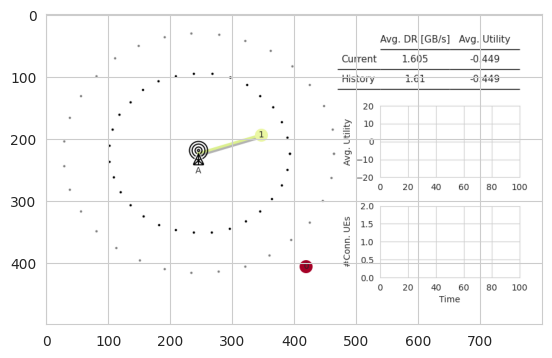

In [137]:
env.reset()
action = env.action_space.sample()
print(action)
new_obs, reward, terminated, truncated, info = env.step(action)
plt.imshow(env.render());

In [ ]:
env.features()

{0: {'connections': array([0.], dtype=float32),
  'snrs': array([1.], dtype=float32),
  'utility': array([-1.], dtype=float32),
  'bcast': array([-1.], dtype=float32),
  'stations_connected': array([0.], dtype=float32)},
 1: {'connections': array([0.], dtype=float32),
  'snrs': array([1.], dtype=float32),
  'utility': array([-1.], dtype=float32),
  'bcast': array([-1.], dtype=float32),
  'stations_connected': array([0.], dtype=float32)}}

In [ ]:
env = CustomEnv(render_mode="rgb_array")
newobs, info = env.reset()
newobs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("Raw observations: ", newobs)

for ue in range(env.NUM_USERS):
  print(f"\nObservations for user {ue + 1}:")
  obs= newobs[ue]
  print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[:env.NUM_STATIONS]}")
  print(f"SNR to the {env.NUM_STATIONS} cells: {obs[env.NUM_STATIONS:2*env.NUM_STATIONS]}")
  print(f"Current utility: {obs[2*env.NUM_STATIONS]}")
  print(f"bcast {obs[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1]}")
  print(f"stations_connected: {obs[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1]}")



Raw observations:  {0: array([ 0.,  1., -1., -1.,  0.], dtype=float32), 1: array([ 0.,  1., -1., -1.,  0.], dtype=float32)}

Observations for user 1:
Current connections to the 1 cells: [0.]
SNR to the 1 cells: [1.]
Current utility: -1.0
bcast [-1.]
stations_connected: [0.]

Observations for user 2:
Current connections to the 1 cells: [0.]
SNR to the 1 cells: [1.]
Current utility: -1.0
bcast [-1.]
stations_connected: [0.]


Reward function for all agents is equal


In [123]:
class DQN:
  def __init__(self, NUM_USERS, NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, learning_rate=0.01, discount_factor=0.9, exploration_prob=1):
    self.NUM_USERS = NUM_USERS
    self.NUM_STATIONS = NUM_STATIONS
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.exploration_prob = exploration_prob


    self.num_action = [self.NUM_STATIONS+1]

    self.policy = np.zeros(DISCRETE_OS_SIZE,dtype = int)

    # Initialize local Q-values: Q[state][agent_action]
    self.q_table = np.zeros(DISCRETE_OS_SIZE + self.num_action)

  def select_action(self, state):
    # Exploration-exploitation trade-off
    if np.random.uniform(0, 1) < self.exploration_prob:
      return np.random.randint(0, self.NUM_STATIONS+1)
    else:
      discrete_state = self.get_discrete_state(state)
      best_action = self.policy[discrete_state]
      return best_action

  def update_q_table(self, state, action, reward, next_state):
    # The local Q-values are updated only when the update leads to an increase in the Q-value
    discrete_state = self.get_discrete_state(state)
    discrete_next_state = self.get_discrete_state(next_state)

    current_max = np.max(self.q_table[discrete_state])
    next_max = np.max(self.q_table[discrete_next_state])
    new_q_value = reward + self.discount_factor * next_max
    current_q_value = self.q_table[discrete_state][action]
    self.q_table[discrete_state][action] = max(current_q_value, new_q_value)

    if np.max(self.q_table[discrete_state]) > current_max:
      self.update_policy(state, np.argmax(self.q_table[discrete_state]))

  def get_discrete_state(self, state):
    # To convert continuous state to index of Q table
    discrete_state = np.zeros(state.shape)
    discrete_state[:env.NUM_STATIONS] = state[:env.NUM_STATIONS] #Connection
    discrete_state[env.NUM_STATIONS:2*env.NUM_STATIONS] = (state[env.NUM_STATIONS:2*env.NUM_STATIONS] - DISCRETE_LOW[env.NUM_STATIONS:2*env.NUM_STATIONS])/discrete_os_win_size[env.NUM_STATIONS:2*env.NUM_STATIONS] # SNR
    discrete_state[2*env.NUM_STATIONS] = (state[2*env.NUM_STATIONS] - DISCRETE_LOW[2*env.NUM_STATIONS])/discrete_os_win_size[2*env.NUM_STATIONS]  # Utility
    discrete_state[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] = (state[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] - DISCRETE_LOW[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1])/discrete_os_win_size[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1]
    discrete_state[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1] =  state[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1]


    discrete_state[env.NUM_STATIONS:2*env.NUM_STATIONS] = [4 if x == 5 else x for x in discrete_state[env.NUM_STATIONS:2*env.NUM_STATIONS]]
    discrete_state[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] = [9 if x == 10 else x for x in discrete_state[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1]]
    if discrete_state[2*env.NUM_STATIONS] == 10:
      discrete_state[2*env.NUM_STATIONS] = 9

    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the Q values for the available actions in the q-table

  def update_policy(self, state, action):
    # print("Policy updated!")
    discrete_state = self.get_discrete_state(state)
    self.policy[discrete_state] = int(action)

In [124]:
DISCRETE_LOW = np.zeros(env.observation_space[0].shape)
DISCRETE_HIGH = np.zeros(env.observation_space[0].shape)
DISCRETE_OS_SIZE = np.zeros(env.observation_space[0].shape)


DISCRETE_OS_SIZE[:env.NUM_STATIONS] = 2 * np.ones(env.NUM_STATIONS) #Current connections
DISCRETE_OS_SIZE[env.NUM_STATIONS:2*env.NUM_STATIONS]= 5 * np.ones(env.NUM_STATIONS) # SNR
DISCRETE_OS_SIZE[2*env.NUM_STATIONS] = 10
DISCRETE_OS_SIZE[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] = 10 * np.ones(env.NUM_STATIONS)
DISCRETE_OS_SIZE[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1] = 2*np.ones(env.NUM_STATIONS)

DISCRETE_LOW[:env.NUM_STATIONS] = 0 * np.ones(env.NUM_STATIONS) #Current connections
DISCRETE_LOW[env.NUM_STATIONS:2*env.NUM_STATIONS]= 0 * np.ones(env.NUM_STATIONS) # SNR
DISCRETE_LOW[2*env.NUM_STATIONS] = -1
DISCRETE_LOW[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] = -1*np.ones(env.NUM_STATIONS)
DISCRETE_LOW[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1] = 0*np.ones(env.NUM_STATIONS)


DISCRETE_HIGH[:env.NUM_STATIONS] = 1 * np.ones(env.NUM_STATIONS) #Current connections
DISCRETE_HIGH[env.NUM_STATIONS:2*env.NUM_STATIONS]= 1*np.ones(env.NUM_STATIONS) # SNR
DISCRETE_HIGH[2*env.NUM_STATIONS] = 1 # Utility
DISCRETE_HIGH[2*env.NUM_STATIONS+1:3*env.NUM_STATIONS+1] = 1 *np.ones(env.NUM_STATIONS)
DISCRETE_HIGH[3*env.NUM_STATIONS+1:4*env.NUM_STATIONS+1] = 1


In [125]:
discrete_os_win_size = (DISCRETE_HIGH - DISCRETE_LOW)/DISCRETE_OS_SIZE
DISCRETE_OS_SIZE = DISCRETE_OS_SIZE.astype(int).tolist()
print("DISCRETE_OS_SIZE: ", DISCRETE_OS_SIZE)

DISCRETE_OS_SIZE:  [2, 5, 10, 10, 2]


In [126]:
def plot_anim(frames, name):
  write_apng(name, frames, delay=80)  # real-time rendering = 40 ms between frames
  display(Image(filename=name))

In [127]:
def sum_reward(scalar_results_list):
  rewards = [scalar_results["mean utility"].sum() for scalar_results in scalar_results_list]
  plt.plot(rewards)
  plt.title("Sum of rewards per episode")
  plt.show()
  print("Sum of rewards per episode: ", rewards)
  return rewards

In [128]:
def runner(agent1, agent2, env):
  frames = []
  obs, info = env.reset()
  scalar_results_list=[]
  ue_results_list =[]
  bs_results_list=[]
  rewards=[]
  num_episodes= 50000
  for i in range(num_episodes):

    selected_action1 = agent1.select_action(obs[0])
    selected_action2 = agent2.select_action(obs[1])
    dict_action = dict({0:selected_action1,1:selected_action2})
    new_obs, reward, terminated, truncated, info = env.step(dict_action)
    if not (terminated or truncated):
      reward = sum(reward.values())/len(reward.values())
      rewards.append(reward)
      agent1.update_q_table(obs[0], selected_action1, reward, new_obs[0])
      agent2.update_q_table(obs[1], selected_action2, reward, new_obs[1])

    obs = new_obs

    # render the environment
    if i > num_episodes - 100:
      frames.append(env.render())

    if terminated or truncated:
      # Save monitoring
      scalar_results, ue_results, bs_results = env.monitor.load_results()
      scalar_results_list.append(scalar_results)
      ue_results_list.append(ue_results)
      bs_results_list.append(bs_results)
      # decay epsilon
      if agent1.exploration_prob >= 0.02:
        agent1.exploration_prob = agent1.exploration_prob * 0.985
      if agent2.exploration_prob >= 0.02:
        agent2.exploration_prob = agent2.exploration_prob * 0.985
      obs, info = env.reset()

  env.close()
  return frames, scalar_results_list, ue_results_list, bs_results_list, rewards

In [129]:
agent1 = DQN(env.NUM_USERS, env.NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, discount_factor=0.9)
agent2 = DQN(env.NUM_USERS, env.NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, discount_factor=0.9)
env = CustomEnv(render_mode="rgb_array")
frames, scalar_results_list, ue_results_list, bs_results_list, rewards = runner(agent1,agent2, env)

plot_anim(frames, "anim_last.png")
reward9 = sum_reward(scalar_results_list)

Output hidden; open in https://colab.research.google.com to view.

In [131]:
def average_of_chunks(data, window_size=100):
    averages = []
    for i in range(0, len(data), window_size):
        chunk = data[i:i+window_size]
        chunk_average = sum(chunk) / len(chunk)
        averages.append(chunk_average)
    return averages

Text(0.5, 1.0, 'Average agents reward per episode')

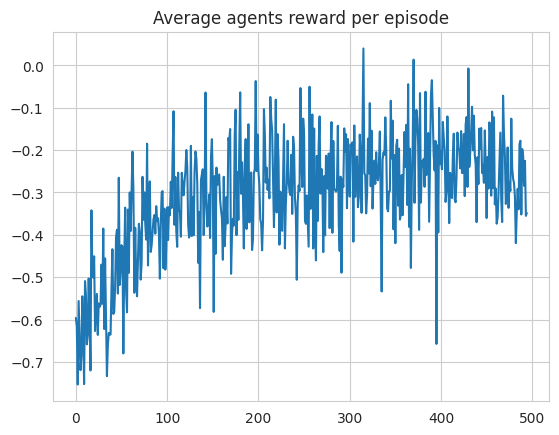

In [132]:
plt.plot(average_of_chunks(rewards))
plt.title("Average agents reward per episode")